In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
test_data = pd.read_csv("../input/emotions-dataset-for-nlp/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("../input/emotions-dataset-for-nlp/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [3]:
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

"""sns.set()
sns.countplot(train_data["Comment"])
plt.show()"""

'sns.set()\nsns.countplot(train_data["Comment"])\nplt.show()'

In [5]:
train_data["length"] = [len(i) for i in train_data["Comment"]]

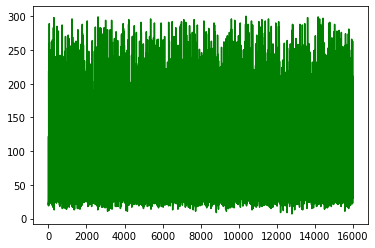

In [6]:
plt.plot(train_data["length"], color = "green")

<AxesSubplot:xlabel='length', ylabel='Density'>

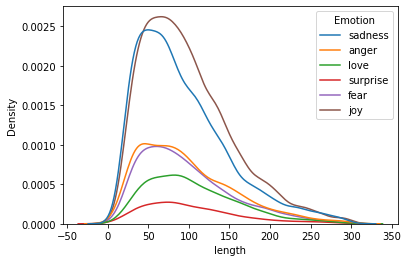

In [7]:
sns.kdeplot(x=train_data["length"], hue=train_data["Emotion"])

# # # ****Data Preprocessing****

In [8]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_data["Emotion"] = lb.fit_transform(train_data["Emotion"])
test_data["Emotion"] = lb.fit_transform(test_data["Emotion"])
validation_data["Emotion"] = lb.fit_transform(validation_data["Emotion"])

In [9]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [10]:
test_data.head()

,Comment,Emotion
0,im feeling rather rotten so im not very ambiti...,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i do...,4
3,i left with my bouquet of red and yellow tulip...,2
4,i was feeling a little vain when i did this one,4


In [11]:
validation_data.head()

,Comment,Emotion
0,im feeling quite sad and sorry for myself but ...,4
1,i feel like i am still looking at a blank canv...,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [12]:
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [13]:
vocab_size = 10000
train_data["length"].max()

300

In [14]:
train_data["length"].min()

7

In [15]:
len_sentence = 150

In [16]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [17]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def text_prepare(data, column):
    print(data.shape)
    stemmer = PorterStemmer()
    corpus = []
    
    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        
        text = text.lower()
        text = text.split()
        
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    embeddec_doc = pad_sequences(sequences=one_hot_word,
                              maxlen=len_sentence,
                              padding="pre")
    print(data.shape)
    return embeddec_doc
        

In [19]:
x_train=text_prepare(train_data, "Comment")
x_validate=text_prepare(validation_data, "Comment")
x_test=text_prepare(test_data, "Comment")

(16000, 3)
(16000, 3)
(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


In [20]:
x_train.shape

(16000, 150)

In [21]:
y_train=train_data["Emotion"]
y_validate=validation_data["Emotion"]
y_test=test_data["Emotion"]

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = np.array(y_train)
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()

In [23]:
y_test = np.array(y_test)
y_validate = np.array(y_validate)

y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()
y_validate = enc.fit_transform(y_validate.reshape(-1,1)).toarray()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [25]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=len_sentence))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(6, activation="softmax"))

In [26]:
model.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [28]:
y_train.shape

(16000, 6)

In [29]:
hist = model.fit(x_train, y_train, epochs = 25, batch_size = 64, validation_data=(x_validate, y_validate),verbose = 1, callbacks= [es, mc])

Epoch 1/25
250/250 [==============================] - 15s 30ms/step - loss: 1.6720 - accuracy: 0.3248 - val_loss: 1.3360 - val_accuracy: 0.5330

Epoch 00001: val_accuracy improved from -inf to 0.53300, saving model to ./model.h5
Epoch 2/25
250/250 [==============================] - 7s 27ms/step - loss: 1.1316 - accuracy: 0.6142 - val_loss: 0.7650 - val_accuracy: 0.7105

Epoch 00002: val_accuracy improved from 0.53300 to 0.71050, saving model to ./model.h5
Epoch 3/25
250/250 [==============================] - 6s 25ms/step - loss: 0.6258 - accuracy: 0.7784 - val_loss: 0.4428 - val_accuracy: 0.8570

Epoch 00003: val_accuracy improved from 0.71050 to 0.85700, saving model to ./model.h5
Epoch 4/25
250/250 [==============================] - 6s 26ms/step - loss: 0.3027 - accuracy: 0.9081 - val_loss: 0.3849 - val_accuracy: 0.8675

Epoch 00004: val_accuracy improved from 0.85700 to 0.86750, saving model to ./model.h5
Epoch 5/25
250/250 [==============================] - 6s 25ms/step - loss: 0.2